In [11]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from Pachaches.functions import clean_PM25frame_coloumns
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pyro.infer import MCMC, NUTS, Predictive, SVI, TraceMeanField_ELBO,HMC
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import osmnx as ox
from pyro import clear_param_store
import pyro.contrib.gp as gp
from pyro.nn import PyroSample
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive,HMC
import torch
import kennard_stone as ks
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc
from bokeh.layouts import column,gridplot
from print_versions import print_versions
from sklearn.metrics import r2_score
from seaborn import clustermap
from sklearn.metrics import mean_squared_error

In [12]:
chem=pd.read_excel(r"chem_polution.xlsx")

In [118]:
cut=np.abs((chem.sample_time.mean()-chem.sample_time)/chem.sample_time.std())

In [126]:
chem=chem.loc[:,cut<2]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [128]:
def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 150, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 150, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 150)

In [130]:
correction=chem.drop(['formaldehyd', 'acetald', 'acetone','cpnr', 'batch_c', 'start_c', 'stop_c', 'batch_n', 'start_n',
       'stop_n',"Nox"],axis=1).loc[chem.no2.isna()==0]
correction["int_week"]=((correction.week/10).round(0)*10).astype(int).astype(str)

In [132]:
correction

,Unnamed: 0,visit,no2,sample_time,week,int_week
0,0,1,7.8,63,35,40
1,2,2,6.5,66,12,10
2,3,3,11.6,82,25,20
3,6,3,17.6,108,8,10
4,7,4,16.7,77,39,40
...,...,...,...,...,...,...
1006,1403,1,5.5,75,21,20
1007,1404,2,5.3,86,51,50
1008,1405,3,3.8,79,26,30
1009,1407,1,10.8,70,31,30


In [134]:
def exp(x, a, b):
    return a * np.exp(b * x)
def linear(x, a, b):
    return a * x +b
def log(x, a, b):
    return a*b**x +b

In [135]:
X_full, y_full=correction.loc[:,["sample_time","no2"]],correction.loc[:,["no2"]]
X_train, X_test, y_train, y_test = ks.train_test_split(X_full, y_full, test_size = 0.2)

2025-01-31 13:29:43,560 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

2025-01-31 13:29:43,585 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



In [138]:
X,y=torch.tensor(X_train.sample_time.values).float(),torch.tensor(y_train.no2.values).float()

In [140]:
clear_param_store()
rbf = gp.kernels.RBF(input_dim=1)

rbf.variance = PyroSample(dist.HalfNormal(torch.tensor(10.)))

rbf.lengthscale = PyroSample(dist.HalfNormal(torch.tensor(20.)))
gpr = gp.models.GPRegression(X,y, rbf)
gpr.noise = PyroSample(dist.HalfNormal(torch.tensor(20.)))

nuts_kernel = NUTS(gpr.model,target_accept_prob=0.8)

mcmc = MCMC(nuts_kernel, num_samples=1000,warmup_steps=2000,num_chains=1)

mcmc.run()

Sample: 100%|███████████████████████████████████████| 3000/3000 [07:21,  6.79it/s, step size=7.66e-01, acc. prob=0.918]


In [141]:
posterior_samples = mcmc.get_samples()

In [142]:
posterior_samples = mcmc.get_samples(500)
posterior_predictive = Predictive(gpr, posterior_samples)(X)
prior = Predictive(gpr, num_samples=500)(X)

pyro_data = az.from_pyro(mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,

)
pyro_data

C:\Users\michael.forsmann\anaconda3\Lib\site-packages\arviz\data\io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> observed_data

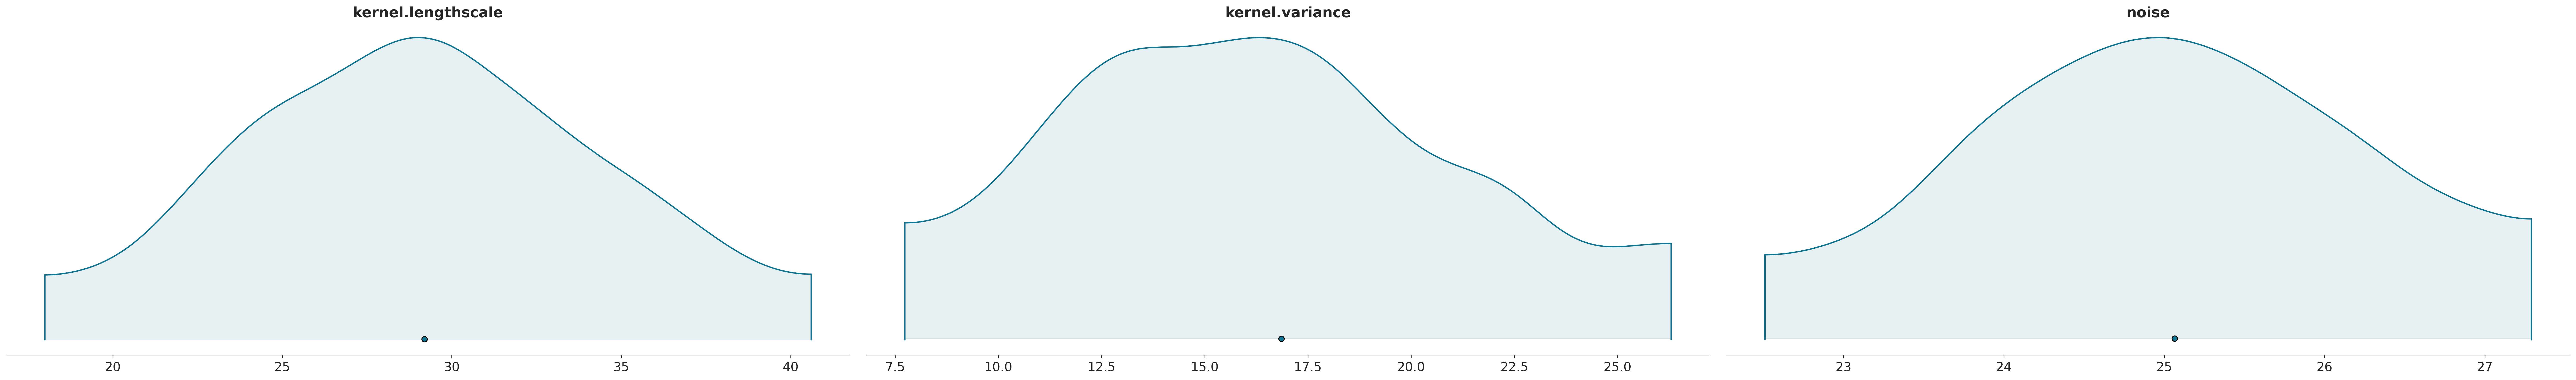

In [143]:
ax = az.plot_density(
    [pyro_data_bc],
    shade=0.1,
)

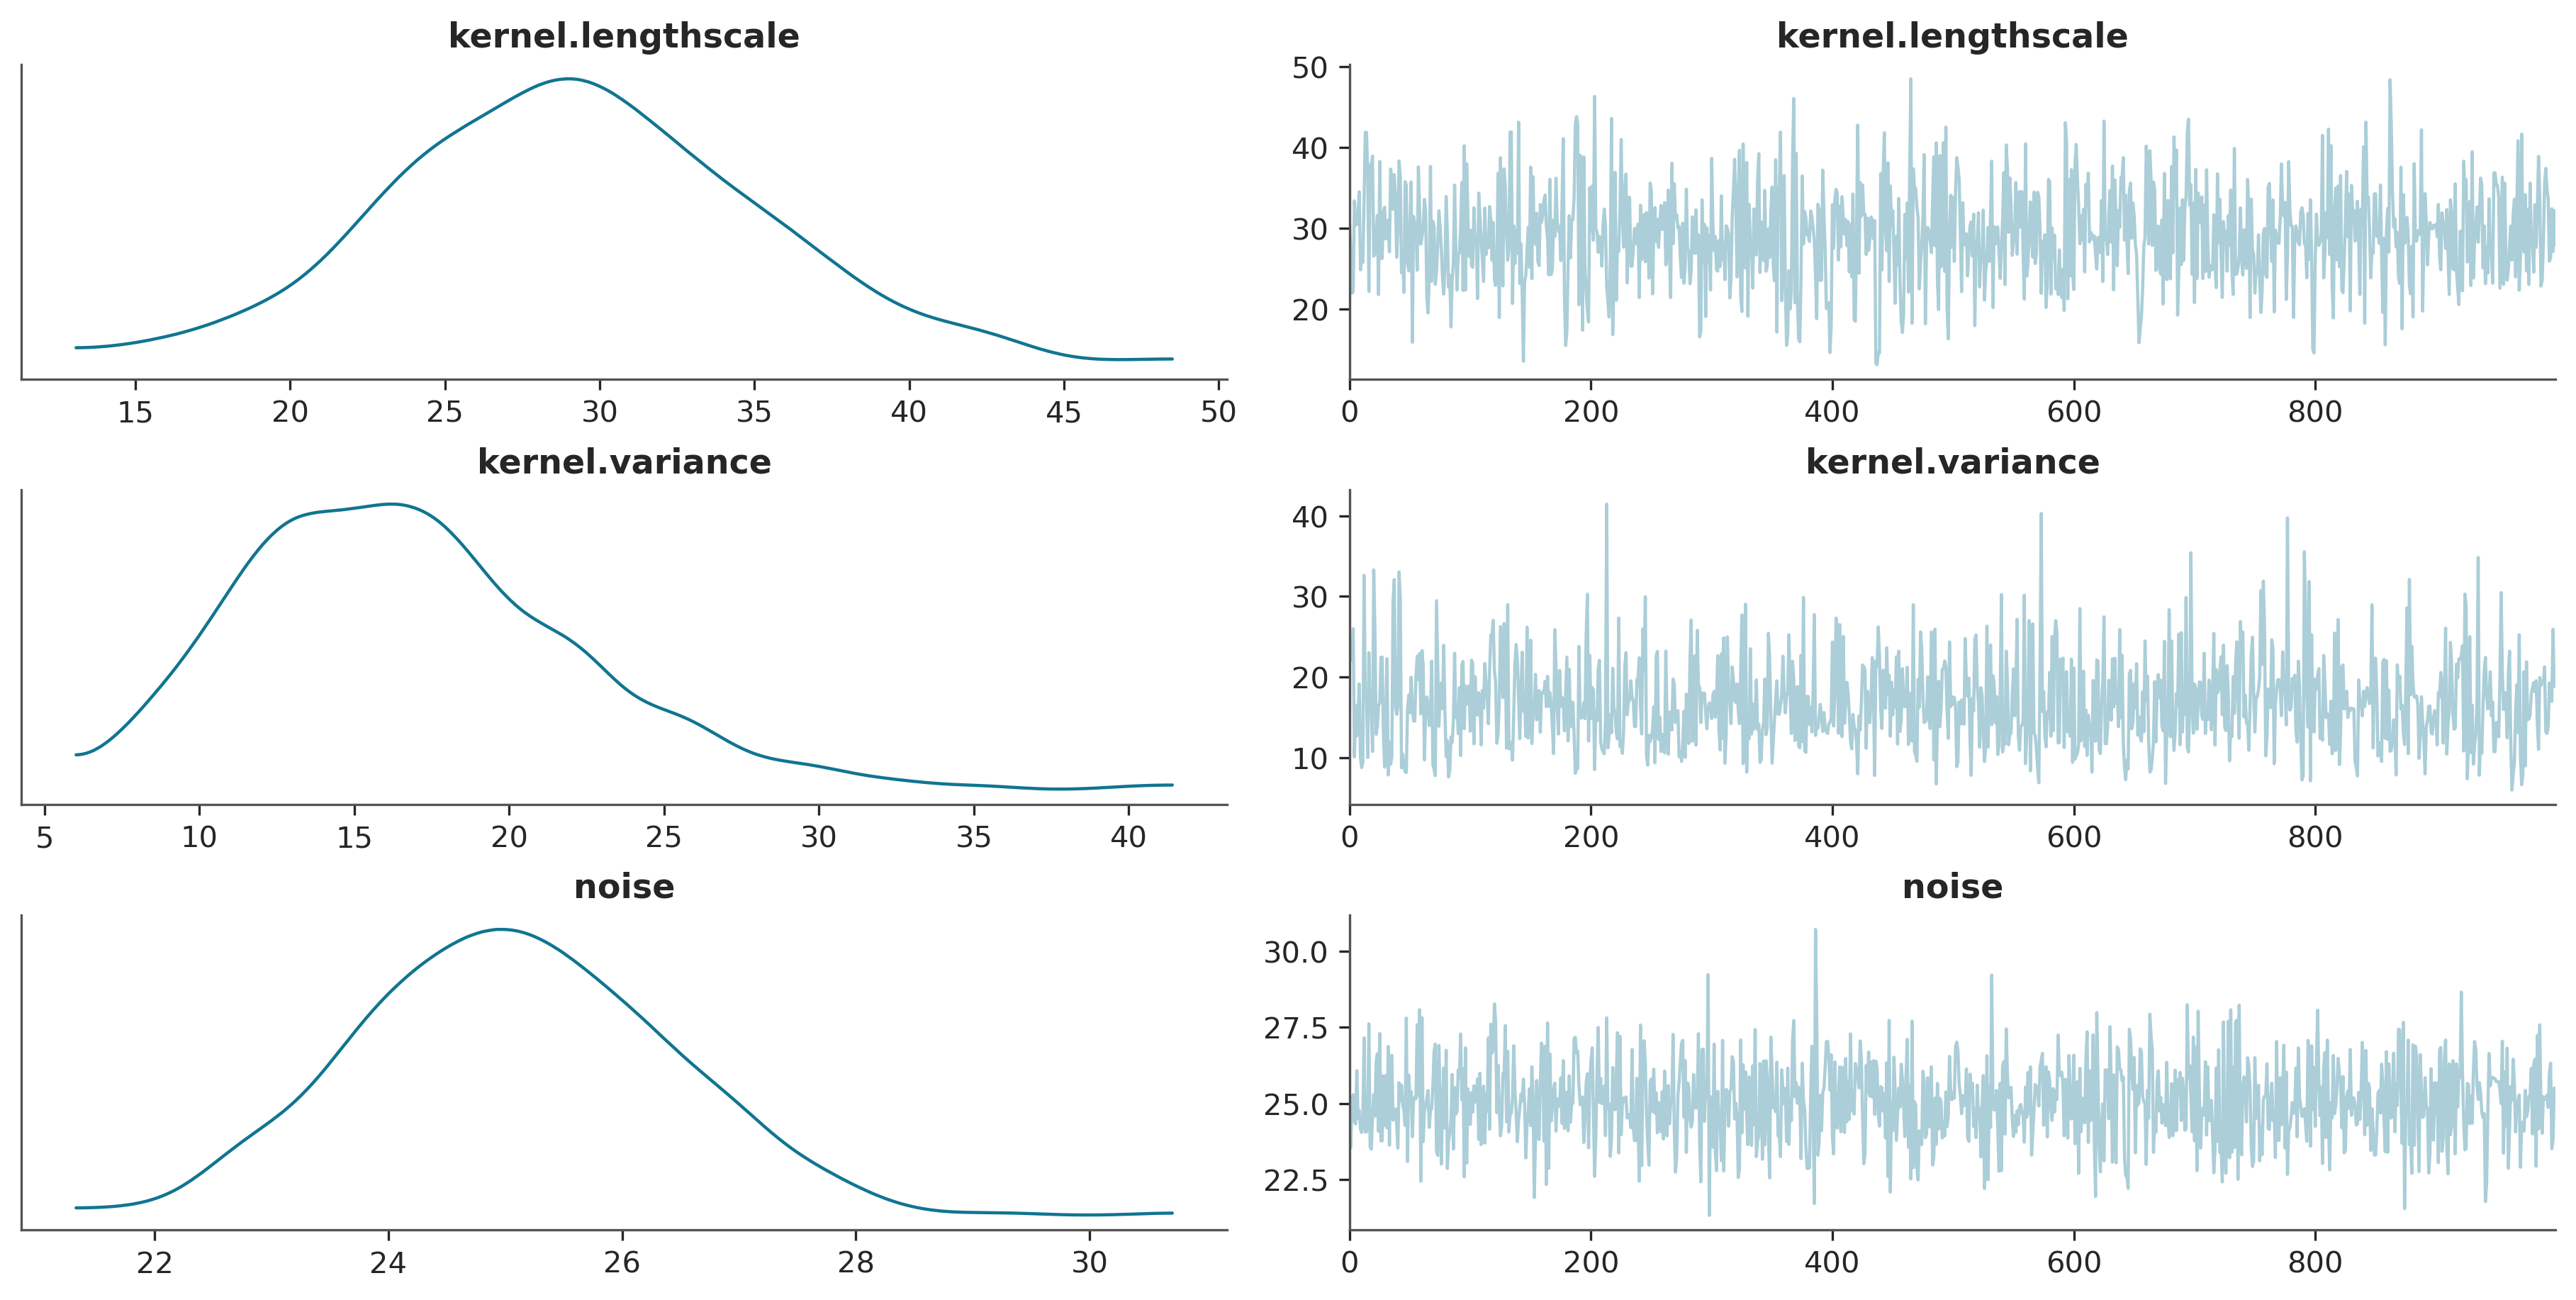

In [144]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_bc)

In [145]:
linmod=torch.linspace(0,140,1000)
pm25_model,pm25_model_std=gpr(linmod)
linmod_np=linmod.detach().numpy()
pm25_model_np,pm25_model_std_np=pm25_model.detach().numpy(),pm25_model_std.detach().numpy()
lower1 = pm25_model_np - gpr.noise.detach().numpy()-pm25_model_std_np
upper1 = pm25_model_np + gpr.noise.detach().numpy()+pm25_model_std_np
data1=pd.DataFrame([linmod_np,lower1,upper1,lower1_bc,upper1_bc],index=["flow","lower","upper"]).T
data1 = ColumnDataSource(data1.reset_index())

NameError: name 'lower1_bc' is not defined

In [ ]:
p = figure(tools="", toolbar_location=None)
p.title.text = "Rolling Standard Deviation"
p.xgrid.grid_line_color=None
p.ygrid.grid_line_alpha=0.5

p.line(linmod_np, pm25_model_np, line_width=3)
p.scatter(X_train.flow, y=y_train.pm_final, color="blue", marker="dot", size=20, alpha=0.4)
band = Band(base="flow", lower="lower", upper="upper",source=data1,fill_alpha=0.8, fill_color="red", line_color="black")
p.add_layout(band)

p1 = figure(tools="", toolbar_location=None)
p1.title.text = "Rolling Standard Deviation"
p1.xgrid.grid_line_color=None
p1.ygrid.grid_line_alpha=0.5

In [75]:
# tell gpr that we want to get samples from guides
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))
print("noise = {}".format(gpr.noise))



variance = 5.605428218841553
lengthscale = 16.74155616760254
noise = 9.796795845031738


In [77]:
exp_curve=curve_fit(lambda t,a,b: a*np.exp(b*t),  X_train.sample_time,y_train)
linear_curve=curve_fit(lambda t,a,b: a * t +b,  X_train.sample_time,y_train)
log_curve=curve_fit(lambda t,a,b: a*b**t +b,  X_train.sample_time,y_train)

ValueError: array must not contain infs or NaNs

In [ ]:
rmse_exp=np.sqrt(np.mean((exp(X_test.sample_time,*exp_curve[0])-y_test)**2))
rmse_linear=np.sqrt(np.mean((linear(X_test.sample_time,*linear_curve[0])-y_test)**2))
rmse_log=np.sqrt(np.mean((linear(X_test.sample_time,*log_curve[0])-y_test)**2))
rmse_exp,rmse_linear,rmse_log

In [ ]:
r2_exp=r2_score(y_test,exp(X_test.sample_time,*exp_curve[0]))
r2_linear=r2_score(y_test,linear(X_test.sample_time,*linear_curve[0]))
r2_log=r2_score(y_test,log(X_test.sample_time,*log_curve[0]))
r2_exp,r2_linear,r2_log

In [140]:
chem["no2_corrected_exp"]=exp(10,*exp_curve[0])/exp(chem.sample_time,*exp_curve[0])*chem.no2
chem["no2_corrected_linear"]=linear(10,*linear_curve[0])/linear(chem.sample_time,*linear_curve[0])*chem.no2
chem["no2_corrected_log"]=log(10,*log_curve[0])/log(chem.sample_time,*log_curve[0])*chem.no2

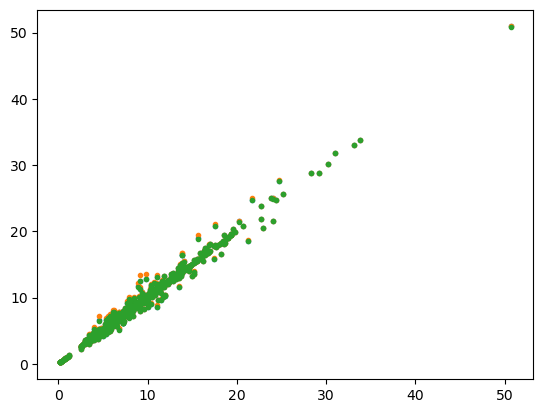

In [142]:
plt.plot(chem.no2,chem.no2_corrected_exp,'.')
plt.plot(chem.no2,chem.no2_corrected_linear,'.')
plt.plot(chem.no2,chem.no2_corrected_log,'.')

In [66]:
chem.sample_time

0        9.000000
1        9.428571
2       11.714286
3       15.428571
4       11.000000
          ...    
1006    10.714286
1007    12.285714
1008    11.285714
1009    10.000000
1010     9.285714
Name: sample_time, Length: 1011, dtype: float64